## this code...

- downloads parliamentary speech corpus in 2020, delete comments from text
- downloads the names and party of representatives from 2018 to 2020
- downloads voting outcomes of the 2018 hungarian parliamentary elections

NOTE: media outlet coprus is added independently

## import necessary packages

In [1]:
import pandas as pd
import numpy as np
import re
import requests
import json
from bs4 import BeautifulSoup
from tqdm import tqdm
from gzip import decompress
from json import loads
from requests import get

tqdm.pandas()
data_dir = "/Users/vigadam/Dropbox/github/media_network/media_data/media-parliament-scaling/data/"

## download and clean 2018-2020 and 2014-2018 parliament text

I asked for data at Kmonitor, they built this [project](https://k-monitor.github.io/parliamentary_debates_open/) and already scraped raw data from parliament website.

In [2]:
corpus_urls = [
    "https://parldatastorage.blob.core.windows.net/parldata-crawler-results/parldata-41.2018-10-07T13-32-33.json.gz",
    "https://parldatastorage.blob.core.windows.net/parldata-crawler-results/parldata-41.2019-01-27T19-35-32.json.gz",
    "https://parldatastorage.blob.core.windows.net/parldata-crawler-results/parldata-41.2019-04-28T13-42-41.json.gz",
    "https://parldatastorage.blob.core.windows.net/parldata-crawler-results/parldata-41.2019-06-13T19-33-47.json.gz",
    "https://parldatastorage.blob.core.windows.net/parldata-crawler-results/parldata-41.2019-10-23T15-03-10.json.gz",
    "https://parldatastorage.blob.core.windows.net/parldata-crawler-results/parldata-41.2020-01-14T19-25-52.json.gz",
    "https://parldatastorage.blob.core.windows.net/parldata-crawler-results/parldata-41.2020-11-29T14-11-09.json.gz",
]

In [2]:
corpus_urls = [
    "https://parldatastorage.blob.core.windows.net/parldata-crawler-results/parldata-40.2018-04-29T19-09-17.json.gz"
]

In [3]:
def get_gzipped_json(url):
    return loads(decompress(get(url).content))

download data

In [4]:
parldata = pd.DataFrame()
for url in corpus_urls:
    chunk = pd.DataFrame(get_gzipped_json(url))
    chunk["date"] = chunk["plenary_sitting_details"].apply(lambda x: x["date"])
    parldata = pd.concat(
        [parldata, chunk.sort_values(by=["date", "id"]).reset_index(drop=True)]
    )

In [5]:
parldata.head()

,speaker_url,video_url,next_speech_url,speaker,id,topic,url,text,plenary_sitting_details,speaker_party,duration,type,prev_speech_url,bill_url,bill_title,started_at,committee,date
0,http://www.parlament.hu/internet/plsql/ogy_kpv...,http://sgis.parlament.hu/archive/playseq.php?d...,http://www.parlament.hu/internet/plsql/ogy_nap...,Dr. Áder János,40-1-1,Ülésnap megnyitása,http://www.parlament.hu/internet/plsql/ogy_nap...,DR. ÁDER JÁNOS köztársasági elnök: Tisztelt Or...,{'video_url': 'http://sgis.parlament.hu/archiv...,NaN,19:03,Az ülésnap megnyitása,NaN,NaN,NaN,10:08:00,köztársasági elnök,2014.05.06.
1,http://www.parlament.hu/internet/plsql/ogy_kpv...,http://sgis.parlament.hu/archive/playseq.php?d...,http://www.parlament.hu/internet/plsql/ogy_nap...,Dr. Turi-Kovács Béla,40-1-10,Mandátumigazolás tárgyalása,http://www.parlament.hu/internet/plsql/ogy_nap...,ELNÖK: Tisztelt Országgyűlés! A határozati ház...,{'video_url': 'http://sgis.parlament.hu/archiv...,Fidesz,0:48,ülésvezetés,http://www.parlament.hu/internet/plsql/ogy_nap...,NaN,NaN,NaN,az Országgyűlés korelnöke,2014.05.06.
2,http://www.parlament.hu/internet/plsql/ogy_kpv...,http://sgis.parlament.hu/archive/playseq.php?d...,http://www.parlament.hu/internet/plsql/ogy_nap...,Dr. Turi-Kovács Béla,40-1-11,Mandátumigazolás tárgyalása,http://www.parlament.hu/internet/plsql/ogy_nap...,ELNÖK: (Csenget.) Tisztelt Országgyűlés! A man...,{'video_url': 'http://sgis.parlament.hu/archiv...,Fidesz,0:26,ülésvezetés,http://www.parlament.hu/internet/plsql/ogy_nap...,NaN,NaN,NaN,az Országgyűlés korelnöke,2014.05.06.
3,http://www.parlament.hu/internet/plsql/ogy_kpv...,http://sgis.parlament.hu/archive/playseq.php?d...,http://www.parlament.hu/internet/plsql/ogy_nap...,Ágh Péter,40-1-12,Mandátumigazolás tárgyalása,http://www.parlament.hu/internet/plsql/ogy_nap...,ÁGH PÉTER (Fidesz): Tisztelt Országgyűlés! A n...,{'video_url': 'http://sgis.parlament.hu/archiv...,Fidesz,0:21,jegyzői ismertetés,http://www.parlament.hu/internet/plsql/ogy_nap...,NaN,NaN,12:05:00,NaN,2014.05.06.
4,http://www.parlament.hu/internet/plsql/ogy_kpv...,http://sgis.parlament.hu/archive/playseq.php?d...,http://www.parlament.hu/internet/plsql/ogy_nap...,Dr. Turi-Kovács Béla,40-1-13,Mandátumigazolás tárgyalása,http://www.parlament.hu/internet/plsql/ogy_nap...,ELNÖK: Tisztelt Országgyűlés! A mandátumvizsgá...,{'video_url': 'http://sgis.parlament.hu/archiv...,Fidesz,2:57,Országgyűlés határozatképes,http://www.parlament.hu/internet/plsql/ogy_nap...,NaN,NaN,NaN,NaN,2014.05.06.


filter for 2020

parldata = (
    parldata.assign(year=lambda x: x["date"].apply(lambda x: x[0:4]))
    .loc[lambda x: (x["year"] == "2020") | (x["year"] == "2019")]
    .reset_index(drop=True)
)

In [6]:
parldata.shape

(53718, 18)

clear text, delete comments (takes a while)

In [7]:
def get_comments(text, regex, stropstrings):
    result = re.findall(regex, text)
    result.append("()")
    for res in result:
        text = text.replace(res, "").strip()
    for string in stopstrings:
        text = text.replace(string, "").strip()
    return text, result


stopstrings = ["-\n", "\n", "\x0c", "\xad"]
regex = re.compile(".*?\((.*?)\)")

parldata["text_comm"] = (
    parldata["text"]
    .str.split(":")
    .progress_apply(
        lambda x: get_comments(" ".join(x[1:]), regex, stopstrings)
        if len(x) > 1
        else x[0]
    )
)

100%|██████████| 53718/53718 [04:31<00:00, 197.55it/s]


In [8]:
parldata["comment"] = parldata["text_comm"].apply(lambda x: x[1] if len(x[1]) > 1 else None)
parldata["text_strip"] = parldata["text_comm"].apply(lambda x: x[0])
mapping = {
    "Fidesz": "Fidesz-KDNP",
    "KDNP": "Fidesz-KDNP",
    "MSZP": "ellenzék",
    "Jobbik": "ellenzék",
    "DK": "ellenzék",
    "LMP": "ellenzék",
    "Párbeszéd": "ellenzék",
}
parldata["oldal"] = parldata["speaker_party"].map(mapping)

Take a look at an example

In [9]:
parldata = parldata.reset_index(drop=True)

In [10]:
print(parldata.loc[100,"comment"])
print("\n")
print(parldata.loc[100,"text_strip"])

['20.00', '()']


Köszönöm. Tisztelt Országgyűlés! Most a képviselőcsoportok 30-30 perces időtartamban fejthetik ki álláspontjukat, a független képviselők pedig összesen 8 perces időtartamban szólalhatnak fel.Először az írásban előre jelentkezett képviselőknek adom meg a szót. Megadom a szót Czunyiné dr. Bertalan Judit képviselő asszonynak.


<AxesSubplot:>

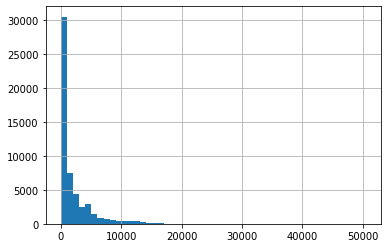

In [11]:
parldata["text_strip"].apply(len).hist(bins=50)

<AxesSubplot:>

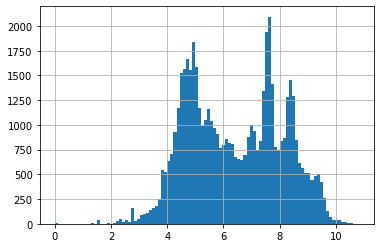

In [12]:
parldata["text_strip"].apply(len).apply(lambda x: np.log(x) if x != 0 else None).hist(bins=100)

In [13]:
parldata = parldata.filter(["speaker","speaker_party","type","text_strip","oldal","date"])

In [14]:
parldata.to_csv(data_dir + "input/parlament_speech_2014-2018.csv", index=False)

## scrape representative name list

In [31]:
# 2018-
tables = pd.read_html(
    "https://hu.wikipedia.org/wiki/2018%E2%80%932022_k%C3%B6z%C3%B6tti_magyar_orsz%C3%A1ggy%C5%B1l%C3%A9si_k%C3%A9pvisel%C5%91k_list%C3%A1ja"
)

In [15]:
# 2014-2018
tables = pd.read_html(
    "https://hu.wikipedia.org/wiki/2014%E2%80%932018_k%C3%B6z%C3%B6tti_magyar_orsz%C3%A1ggy%C5%B1l%C3%A9si_k%C3%A9pvisel%C5%91k_list%C3%A1ja"
)

In [16]:
names = pd.concat(
    [
        tables[3],
        tables[4],
        tables[5],
    ]
)

names = names.dropna(subset=["Név"])
names["Név"] = names["Név"].str.split("[").apply(lambda x: x[0])
names = names[["Frakció","Mandátum kezdete","Mandátum vége","Név","Választókerület"]]

In [20]:
names.to_csv(data_dir + "input/representative_names_2014-2018.csv")

## scrape vote outcomes in the 2018 parliamentary elections

In [34]:
resp = requests.get("https://valtor.valasztas.hu/valtort/jsp/mkiv.jsp?EA=38&URL=7")
soup = BeautifulSoup(resp.content)

In [35]:
counties = ["https://valtor.valasztas.hu/valtort/jsp/" + i.get("href") for i in soup.find_all("a")]

In [36]:
constit = []
for county in counties:
    resp = requests.get(county)
    soup = BeautifulSoup(resp.content)
    constit = constit + [
        "https://valtor.valasztas.hu/valtort/jsp/" + i.get("href")
        for i in soup.find_all("a")
    ]

In [37]:
df = pd.DataFrame()

for const in constit:

    resp = requests.get(const)
    soup = BeautifulSoup(resp.content)

    df_c = pd.concat(pd.read_html(str(soup.find_all("table")[-1]), header=0))
    df_c["const"] = " ".join(
        [
            soup.find_all("font", {"size": 4})[1].get_text(),
            soup.find_all("font", {"size": 3})[1].get_text(),
        ]
    )
    df = pd.concat([df, df_c])
    
df["const"] = df["const"].str.replace("A választás eredményes", "BUDAPEST")

In [38]:
df.to_csv(data_dir +"input/vote_outcomes_2018.csv")